# "Seven months commuting to the office"
> "Data Analysis - trip to and from the office"

- toc: True
- branch: master
- badges: true
- categories: ['Data Analysis','Data Viz']
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

Objective of this notebook:
- Plot data taken from AppFibr App
- Analyse are there optimum time to leave home or office
- Analyse if there are differences of travel time in different days
- Analyse if there are differences of travel to the office vs from the office
- Analyse if there are significant differences between two rideshare providers
- Analyse if there are optimum time to leave home or office

# Import python module

In [1]:
# import module
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import data from Gsheet & Data Cleaning

In [2]:
df = pd.read_csv('trip_tracker_cleaned.csv')

In [3]:
# Data Cleaning
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# convert the datetime to the right format
df['Date'] = pd.to_datetime(df.Date)
df['From_time'] = pd.to_datetime(df.From_time)
df['To_time'] = pd.to_datetime(df.To_time)

# convert fare to the right format
df['Fare'] = df['Fare'].str.replace(',', '').apply(pd.to_numeric)



Create boolean column to flag only for travel time during peak traffic hour (7-9AM & 4-7PM). Outside these time, the data shall be filtered. Also create additional column to describe which day of the week. 

In [4]:
# create boolean column to consider data only for peak traffic hour (7-9AM & 4-7PM)
df['peak_hour'] = df['From_time'].dt.hour.between(7, 9, inclusive=True) | df['From_time'].dt.hour.between(16, 18, inclusive=True)

# create column of day of the week
df['day_of_week'] = df['Date'].dt.day_name()

In [5]:
# filter for only peak traffic hour
df = df.loc[df.peak_hour]
df = df.reset_index(drop=True)
df 

,Date,Provider,From,From_time,To,To_time,Fare,Duration,from_home,peak_hour,day_of_week
0,2024-01-16,Provider1,Home,2024-01-16 07:48:00,Office,2024-01-16 08:32:00,46500,44,1,True,Tuesday
1,2024-01-15,Provider1,Office,2024-01-15 17:27:00,Home,2024-01-15 18:24:00,44000,57,0,True,Monday
2,2024-01-15,Provider2,Home,2024-01-15 07:55:00,Office,2024-01-15 08:26:00,61500,31,1,True,Monday
3,2024-01-12,Provider1,Home,2024-01-12 08:05:00,Office,2024-01-12 08:43:00,53500,38,1,True,Friday
4,2024-01-11,Provider1,Home,2024-01-11 08:01:00,Office,2024-01-11 08:46:00,40500,45,1,True,Thursday
...,...,...,...,...,...,...,...,...,...,...,...
80,2023-10-19,Provider1,Office,2023-10-19 16:31:00,Home,2023-10-19 17:23:00,49500,52,0,True,Thursday
81,2023-12-19,Provider2,Home,2023-12-19 07:48:00,Office,2023-12-19 08:33:00,51000,45,1,True,Tuesday
82,2023-09-25,Provider1,Home,2023-09-25 07:56:00,Office,2023-09-29 08:38:00,56000,42,1,True,Monday
83,2023-08-10,Provider1,Home,2023-08-10 07:39:00,Office,2023-08-10 08:28:00,50500,49,1,True,Thursday


In [6]:
df.dtypes

Date           datetime64[ns]
Provider               object
From                   object
From_time      datetime64[ns]
To                     object
To_time        datetime64[ns]
Fare                    int64
Duration                int64
from_home               int64
peak_hour                bool
day_of_week            object
dtype: object

In [7]:
df.describe()

,Fare,Duration,from_home
count,85.000000,85.000000,85.000000
mean,51735.294118,48.905882,0.529412
std,8709.459907,11.107294,0.502096
min,38000.000000,29.000000,0.000000
25%,45500.000000,40.000000,0.000000
50%,50000.000000,48.000000,1.000000
75%,56000.000000,55.000000,1.000000
max,75000.000000,83.000000,1.000000


# Data Analysis

## Duration and Fare comparison based on travel origination

Once filtering for travels outside peak hours, we are left with 85 trips with some interesting observations:
- I took significantly more trips with Provider1 than Provider2. No, I did not realised that.
- The data matched my expectation, where I suspected that trips from home were faster and generally more expensive.
- On average Provider1 was cheaper than Provider2, including the minimum fare ever offered to me.This could be an interesting finding on their pricing model, but take this with a grain of salt due to the small sample size especially for trips conducted via Provider2.
- Even though fare differences between the 2 providers were somewhat expected, but I did not expect that the average travel time frome Home by Provider1 (42 mins) is significantly lower than Provider2 (48 mins). Route differences may play a factor here.

### Duration (in minutes)

In [8]:
# Describe Duration (in minutes)
df.groupby(["From", "Provider"])['Duration'].describe().loc[:,['count','mean','min','max']].round().astype(int)

count  mean  min  max
From   Provider                        
Home   Provider1     27    42   29   67
       Provider2     18    48   31   69
Office Provider1     22    54   33   73
       Provider2     18    53   29   83

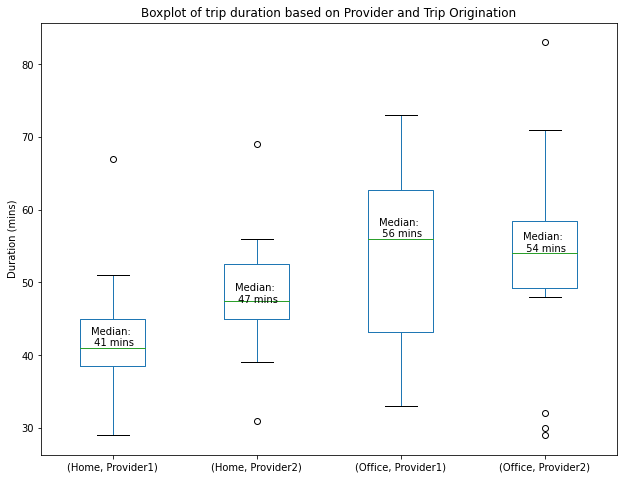

In [9]:
# Boxplot for travel duration data distribution
fig, ax = plt.subplots(figsize=(10, 8))

# Creating plot
bp = df.boxplot("Duration", by=["From", "Provider"], ax=ax)
plt.suptitle('')

# Setting title to graph
ax.set_title('Boxplot of trip duration based on Provider and Trip Origination')

# Label x-axis and y-axis
ax.set_ylabel('Duration (mins)')
ax.set_xlabel('')

# Remove grid
ax.grid(False)

# Add median value text annotation
for i, box in enumerate(ax.get_xticks()):
    # Calculate median value for each box
    median_val = df.groupby(["From", "Provider"]).median().iloc[i]["Duration"].astype(int)
    
    # Add text annotation at the median position
    ax.text(box, median_val, f'Median: \n {median_val} mins', verticalalignment='bottom', horizontalalignment='center', color='black')

# Show plot
plt.show()

### Fare (in IDR)

In [10]:
# Describe Fare (in IDR)
df.groupby(["From", "Provider"])['Fare'].describe().loc[:,['count','mean','min','max']].round(0).astype(int)

count   mean    min    max
From   Provider                             
Home   Provider1     27  53630  40500  71000
       Provider2     18  57472  48000  75000
Office Provider1     22  47227  38000  69500
       Provider2     18  48667  44500  63500

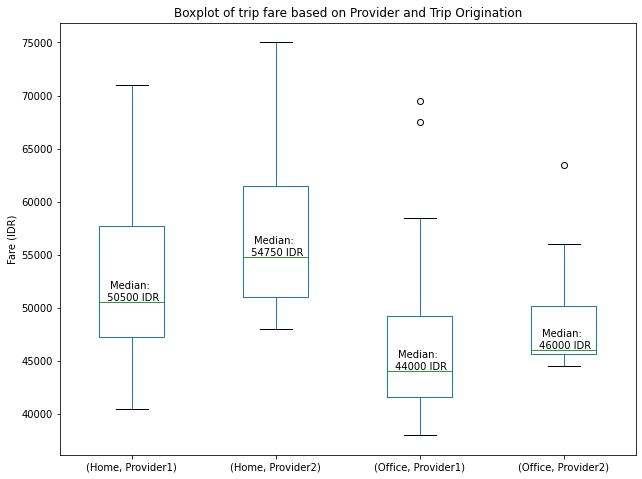

In [11]:
# Boxplot for travel duration data distribution
fig, ax = plt.subplots(figsize=(10, 8))

# Creating plot
bp = df.boxplot("Fare", by=["From", "Provider"], ax=ax)
plt.suptitle('')

# Setting title to graph
ax.set_title('Boxplot of trip fare based on Provider and Trip Origination')

# Label x-axis and y-axis
ax.set_ylabel('Fare (IDR)')
ax.set_xlabel('')

# Remove grid
ax.grid(False)

# Add median value text annotation
for i, box in enumerate(ax.get_xticks()):
    # Calculate median value for each box
    median_val = df.groupby(["From", "Provider"]).median().iloc[i]["Fare"].astype(int)
    
    # Add text annotation at the median position
    ax.text(box, median_val, f'Median: \n {median_val} IDR', verticalalignment='bottom', horizontalalignment='center', color='black')

# Show plot
plt.show()

Overall this high level summary suggests that we should deep dive the data even more to answer some of these questions that I would like to explore:
- Are there travel time variability for different days? I somewhat believe that traffic is generally worse on Monday mornings.
- Are there correlation between fare and travel duration? I find it weird that for similar travel distance, the travel fare from the office is significantly cheaper than from home, especially given that it was common knowledge that the evening traffic around TB Simatupang Road is extremly bad. Even Google Map presents the traffic in dark red!
- Are there statistically different travel fare and duration between trips provided by Provider1 and Provider2? If any, which providers maybe cheaper.
- Are there optimum time to leave home or office based on the data collected?

## Travel time for different days

In [12]:
# Describe Duration (in minutes)
df.groupby(["From", "day_of_week"])['Duration'].describe().loc[:,['count','mean','min','max']].round().astype(int)

count  mean  min  max
From   day_of_week                       
Home   Friday           4    44   38   50
       Monday          19    45   31   67
       Thursday         7    44   36   49
       Tuesday          7    45   29   69
       Wednesday        8    45   37   56
Office Friday           5    59   54   66
       Monday          14    47   32   59
       Thursday         7    61   51   73
       Tuesday          5    45   30   65
       Wednesday        9    59   29   83

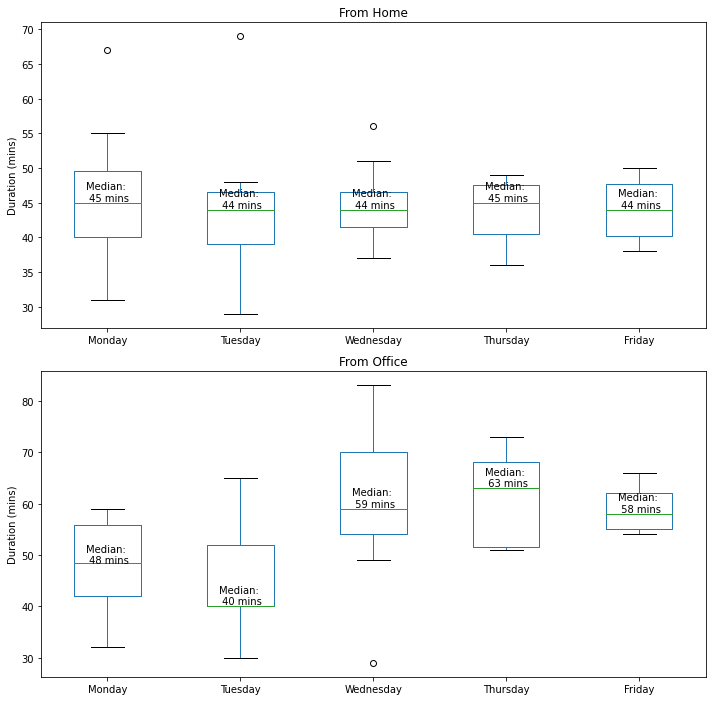

In [13]:
# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert 'day_of_week' column to categorical with specified order
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

# Boxplot for travel duration data distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Creating top subplot
bp1 = df[df['From']=='Home'].boxplot("Duration", by="day_of_week", ax=ax1)
ax1.set_title('From Home')
ax1.set_xlabel('')
ax1.set_ylabel('Duration (mins)')
ax1.grid(False)

# Add median value text annotation
for i, box in enumerate(ax1.get_xticks()):
    # Calculate median value for each box
    median_val = df[df['From']=='Home'].groupby("day_of_week").median().iloc[i]["Duration"].astype(int)
    
    # Add text annotation at the median position
    ax1.text(box, median_val, f'Median: \n {median_val} mins', verticalalignment='bottom', horizontalalignment='center', color='black')


# Creating bottom subplot
bp2 = df[df['From']=='Office'].boxplot("Duration", by="day_of_week", ax=ax2)
ax2.set_title('From Office')
ax2.set_xlabel('')
ax2.set_ylabel('Duration (mins)')

# Add median value text annotation
for i, box in enumerate(ax2.get_xticks()):
    # Calculate median value for each box
    median_val = df[df['From']=='Office'].groupby("day_of_week").median().iloc[i]["Duration"].astype(int)
    
    # Add text annotation at the median position
    ax2.text(box, median_val, f'Median: \n {median_val} mins', verticalalignment='bottom', horizontalalignment='center', color='black')


plt.suptitle('')

# Remove grid for the second subplot
ax2.grid(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

It turns out the data does not show that there are significant travel time on Monday compared to other days. Perhaps it was simply psychological bias since I went to the office more frequently on Mondays for weekly report session with the management team. 

However, even with limited data on travel days other than Monday, it is interesting to see that travel from the office is significantly longer on Wednesdays to Fridays. Travels during later part of the week are often over 10 minutes longer compared to travels during Mondays and Tuesdays. I certainly did not realise that. 

## Correlation between fare and duration

One usually assumes that rideshares' fare is correlated with travel duration (or distance). This is true even for traditional taxis where the meter primarily count the distance travelled. The meter even includes the time spent on travel even when its not moving, eg: in traffic. 

We have already seen from the data earlier that  the travel fares and durations could differ significantly even for the same travel distance. But, are there any correlation between travel fare and durations? I am especially curious for my travel originated from the office where it was well known that the traffic in TB Simatupang is exteremely bad in the evening. Furthermore it is not unreasonable to assume that the pricing model from the rideshare providers may account for potential delays during travel since similar model has been adopted by the taxis. Afterall they can get these potential delays data from Google Map route traffic, the same as how we as customers see potential time taken in Google Map.  

In [14]:
# Import stats module to calculate LBF
import scipy.stats

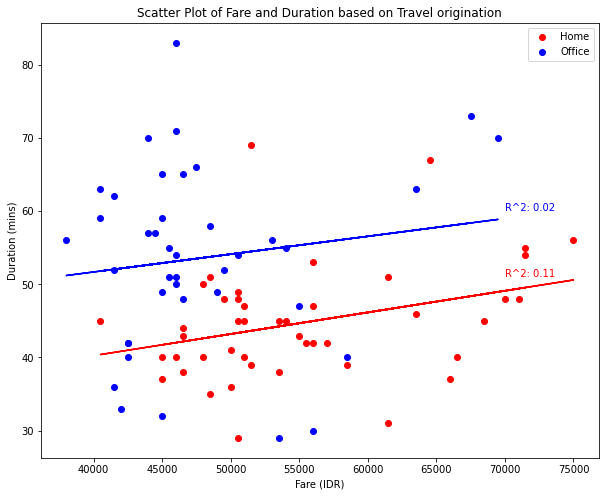

In [26]:
# Scatter plot for Fare and Duration with color based on 'From'
fig, ax = plt.subplots(figsize=(10, 8))

# calculate LBF & the R2
m1, b1, r_value1, p_value1, std_err1 = scipy.stats.linregress(df[df['From'] == 'Home'] ['Fare'],
                                                                  df[df['From'] == 'Home'] ['Duration'])
m2, b2, r_value2, p_value2, std_err2 = scipy.stats.linregress(df[df['From'] == 'Office'] ['Fare'],
                                                                  df[df['From'] == 'Office'] ['Duration'])

# Plot 2 scatter plot & their LBF & display the R^2
scatter1 = ax.scatter(df[df['From'] == 'Home'] ['Fare'], df[df['From'] == 'Home'] ['Duration'],c='red',label='Home')
ax.plot(df[df['From'] == 'Home'] ['Fare'], m1*df[df['From'] == 'Home'] ['Fare'] + b1,c='red')
ax.annotate('R^2: ' + str("{:.2f}".format(r_value1**2)), xy=(70000,51),c='red')

scatter2 = ax.scatter(df[df['From'] == 'Office'] ['Fare'], df[df['From'] == 'Office'] ['Duration'],c='blue',label='Office')
ax.plot(df[df['From'] == 'Office'] ['Fare'], m2*df[df['From'] == 'Office'] ['Fare'] + b2,c='blue')
ax.annotate('R^2: ' + str("{:.2f}".format(r_value2**2)), xy=(70000,60),c='blue')

# Setting title to graph
ax.set_title('Scatter Plot of Fare and Duration based on Travel origination')
ax.set_xlabel('Fare (IDR)')
ax.set_ylabel('Duration (mins)')

# Add legend
ax.legend()

# Show plot
plt.show()

Looks like there is no strong correlation between travel fare and travel duration, as indicated by the low $R^{2}$

One hypothesis could be that the demand for service is given higher weight in the rideshares' pricing model. Logically my morning trip from Mega Kuningan in the CBD should have higher demand from other prospective riders. In contrast, my evening trip from TB Simatupang simply has less demand around this area. 

## Hypothesis testing

In this section we will conduct hypothesis testing whether there are significant trip and fare differences between the two providers. If pvalue < 0.05 then we can considered that the samples are statistically different.

In [16]:
# import stats module
from scipy.stats import ttest_ind

### Overall fare from home vs from office

In [17]:
# ttest for fare of home vs office

#define samples
cat1 = df[df['From'] == 'Home'] ['Fare']
cat2 = df[df['From'] == 'Office'] ['Fare']

#perform Welch's t-test
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=4.220692123629692, pvalue=6.191721153034327e-05)

Fare originated from home and office are statistically different

### Fare from home for Provider1 vs Provider2

In [18]:
# ttest for fare from home between provider 1 & 2

#define samples
cat1 = df[(df['From'] == 'Home') & (df['Provider'] == 'Provider1')] ['Fare']
cat2 = df[(df['From'] == 'Home') & (df['Provider'] == 'Provider2')] ['Fare']

#perform Welch's t-test
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=-1.4881017656220044, pvalue=0.14402157661902457)

There is no significant difference between fare for trips originated from home for rides conducted via Provider1 and Provider2

### Fare from office for Provider1 vs Provider2

In [19]:
# ttest for fare from office between provider 1 & 2

#define samples
cat1 = df[(df['From'] == 'Office') & (df['Provider'] == 'Provider1')] ['Fare']
cat2 = df[(df['From'] == 'Office') & (df['Provider'] == 'Provider2')] ['Fare']

#perform Welch's t-test
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=-0.6291093039880321, pvalue=0.5330415051263946)

There is no significant difference between fare for trips originated from office for rides conducted via Provider1 and Provider2

### Overall duration from home vs from office

In [20]:
# ttest for duration of home vs office

#define samples
cat1 = df[df['From'] == 'Home'] ['Duration']
cat2 = df[df['From'] == 'Office'] ['Duration']

#perform Welch's t-test
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=-3.985717654046981, pvalue=0.0001439696232272107)

Trip duration originated from home and office are statistically different

### Duration from home for Provider1 vs Provider2

In [21]:
# ttest for fare from home between provider 1 & 2

#define samples
cat1 = df[(df['From'] == 'Home') & (df['Provider'] == 'Provider1')] ['Duration']
cat2 = df[(df['From'] == 'Home') & (df['Provider'] == 'Provider2')] ['Duration']

#perform Welch's t-test
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=-2.6960841168660505, pvalue=0.009974894309153371)

Trip duration from home is statistically different between Provider1 and Provider2

### Duration from office for Provider1 vs Provider2

In [22]:
# ttest for fare from office between provider 1 & 2

#define samples
cat1 = df[(df['From'] == 'Office') & (df['Provider'] == 'Provider1')] ['Duration']
cat2 = df[(df['From'] == 'Office') & (df['Provider'] == 'Provider2')] ['Duration']

#perform Welch's t-test
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=0.19722782722858406, pvalue=0.8447004284799403)

There is no significant difference between trips duration originated from office if taken by Provider1 and Provider2

## Optimum time to leave home or office

This section shall explores my original goal of collecting these data. Are there optimum time to leave home or office to minimise the duration of being stuck in Jakarta's traffic.

For simplicity, I will group by the travel start time in 5 minutes interval. Then we can see the average travel time for each of those 5 minutes group to see if an optimum time can be observed.

In [27]:
# Extract only the time component

# Group by every 5 minutes
df['hour'] = pd.to_datetime(df['From_time']).dt.hour
df['minute'] = pd.to_datetime(df['From_time']).dt.minute
df['interval'] = df.apply(lambda row: f"{row['hour']:02d}:{(row['minute'] // 5) * 5:02d}", axis=1)


# Group by the calculated intervals
result = df.groupby('interval')['Duration'].agg( mean=( 'mean'), count=('count')).reset_index()

result

,interval,mean,count
0,07:15,54.000000,1
1,07:30,46.000000,3
2,07:35,49.000000,7
3,07:40,42.636364,11
4,07:45,45.066667,15
5,07:50,44.250000,4
6,07:55,36.500000,2
7,08:00,45.000000,1
8,08:05,38.000000,1
9,16:20,63.000000,3


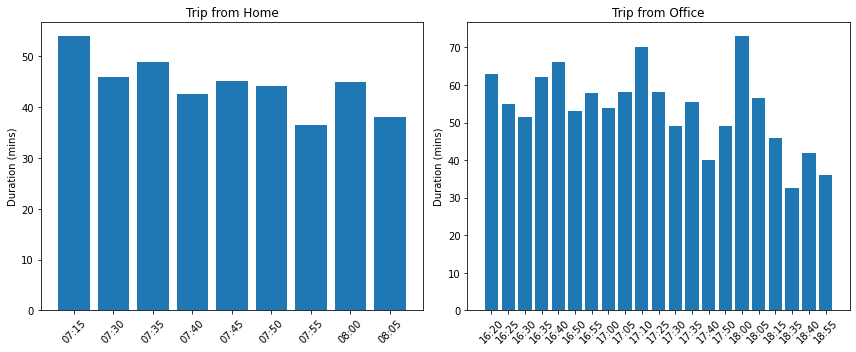

In [24]:
# Create two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

result['hour'] = pd.to_datetime(result['interval']).dt.hour

# Plot for data before midday
axs[0].bar(result[result['hour'] < 12]['interval'], result[result['hour'] < 12]['mean'])
axs[0].set_title('Trip from Home')
axs[0].set_xlabel('')
axs[0].set_ylabel('Duration (mins)')
axs[0].tick_params(axis='x', rotation=45)

# Plot for data after midday
axs[1].bar(result[result['hour'] >= 12]['interval'], result[result['hour'] >= 12]['mean'])
axs[1].set_title('Trip from Office')
axs[1].set_xlabel('')
axs[1].set_ylabel('Duration (mins)')
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

There is no indication of an optimum time to leave home or office. Though there are a slight indication that leaving home later resulting in less traffic to the office. 

Another minor observation is that I was significantly more consistent to leave at home around the 7:40-7:50 window, where this 10 minutes window represents 58% of my travel start time in the morning. In contrast, my start time leaving the office is way more distributed, which could be contributed by more variety of workloads at the office. 